In [35]:
import sys
!{sys.executable} -m pip install tf-models-official

  Using cached tf_models_official-2.8.0-py2.py3-none-any.whl (2.2 MB)
     -------------------------------------- 98.2/98.2 KB 200.8 kB/s eta 0:00:00
     -------------------------------------- 234.6/234.6 KB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 6.2 MB/s eta 0:00:00
     ---------------------------------------- 90.7/90.7 KB ? eta 0:00:00
     ------------------------------------- 352.1/352.1 KB 10.7 MB/s eta 0:00:00
     ------------------------------------- 755.7/755.7 KB 24.0 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 13.9 MB/s eta 0:00:00
     ---------------------------------------- 59.0/59.0 KB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached py-cpuinfo-8.0.0.tar.gz (99 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 43.6/43.6 KB

Traceback (most recent call last):
  File "C:\Users\aligo\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\aligo\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\aligo\anaconda3\lib\site-packages\pip\__main__.py", line 31, in <module>
    sys.exit(_main())
  File "C:\Users\aligo\anaconda3\lib\site-packages\pip\_internal\cli\main.py", line 70, in main
    return command.main(cmd_args)
  File "C:\Users\aligo\anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 101, in main
    return self._main(args)
  File "C:\Users\aligo\anaconda3\lib\contextlib.py", line 120, in __exit__
    next(self.gen)
  File "C:\Users\aligo\anaconda3\lib\site-packages\pip\_internal\cli\command_context.py", line 20, in main_context
    yield
  File "C:\Users\aligo\anaconda3\lib\contextlib.py", line 525, in __exit__
    raise exc_details[1]
  File "C:\Users\aligo\anaconda3\lib\contextl

In [36]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

import pandas as pd
import numpy as np

# Get data

In [37]:
df = pd.read_csv('./../../labeledTweets/allLabeledTweets.csv')
df = df[['id', 'message', 'label']]
df.head()

,id,message,label
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0


In [38]:
df['label'].value_counts()

0    968
2    647
1    410
Name: label, dtype: int64

In [39]:
newLine ="\\n|\\r"
df['clean_message'] = df['message'].str.replace(newLine,' ',regex=True).str.strip()
df.head()

,id,message,label,clean_message
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0,Tiek vērtēti trīs potenciālie airBaltic invest...
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0,Augulis: #airBaltic “potenciālie pircēji ir no...
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0,airBaltic uzsāks lidojumus uz diviem jauniem g...
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0,Ministrs: Sarunas turpinās ar trīs potenciālaj...
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...


# Train, validate split

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [41]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['label', 'data_type']).count()

id  message  clean_message
label data_type                             
0     train      823      823            823
      val        145      145            145
1     train      348      348            348
      val         62       62             62
2     train      550      550            550
      val         97       97             97

In [42]:
df.head()

,id,message,label,clean_message,data_type
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0,Tiek vērtēti trīs potenciālie airBaltic invest...,train
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0,Augulis: #airBaltic “potenciālie pircēji ir no...,val
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0,airBaltic uzsāks lidojumus uz diviem jauniem g...,train
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0,Ministrs: Sarunas turpinās ar trīs potenciālaj...,train
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,train


In [43]:
# df.to_csv('./tweets_base.csv', index=False)

# df = pd.read_csv('./../labeledTweets/p_n_n_and_labeled_corpus_train_val.csv')

## Balance training data

In [44]:
df[df.data_type=='train']['label'].value_counts()

0    823
2    550
1    348
Name: label, dtype: int64

In [45]:
df[df.data_type=='train'].head()

,id,message,label,clean_message,data_type
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0,Tiek vērtēti trīs potenciālie airBaltic invest...,train
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0,airBaltic uzsāks lidojumus uz diviem jauniem g...,train
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0,Ministrs: Sarunas turpinās ar trīs potenciālaj...,train
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,train
5,1481060,airBaltic uzsāks lidojumus uz Sočiem un Kaļiņi...,0,airBaltic uzsāks lidojumus uz Sočiem un Kaļiņi...,train


In [46]:
df_train = [df[df.data_type=='train'].clean_message, df[df.data_type=='train'].label]
df_train = pd.concat(df_train, axis=1, keys=["clean_message", "label"])

df_0 = df_train[df_train['label']==0]
df_1 = df_train[df_train['label']==1]
df_2 = df_train[df_train['label']==2]

df_0_downsampled = df_0.sample(df_1.shape[0], random_state=42)
df_2_downsampled = df_2.sample(df_1.shape[0], random_state=42)

df_train = pd.concat([df_0_downsampled, df_2_downsampled, df_1])

df_train['label'].value_counts()

0    348
1    348
2    348
Name: label, dtype: int64

In [47]:
df_train.head()

,clean_message,label
1526,"@laura_freiberga Sveiki! Lūdzu, atsūti DM savu...",0
567,Tiešraide jau pēc 30 minūtēm! @hsrigahockey -...,0
260,"ES ATVAINOJOS, VAI IR KĀDS IZDEVĪGĀKS PAR LATV...",0
560,Tiešraide jau pēc 30 minūtēm! @hsrigahockey -...,0
777,SEB ievieš Latvijā pirmo indeksu plānu pensiju...,0


In [48]:
# Shuffle rows
import sklearn

df_train = sklearn.utils.shuffle(df_train, random_state=0)

df_train.head()

,clean_message,label
700,Šodien norisinās SEB MTB maratons. Finišs @val...,0
1911,@digidigidong Sveiks! Tas neattiecas uz mūsu e...,1
505,"@BriedeBriede @kungavsand_ Starpcitu, Maxima t...",1
1471,Taisnība ir uzvarējusi! Martins Dukurs kļūst p...,1
1537,@houdshwick Спасибо за мнение.^el,0


# Tokenizer "sentence-transformers/LaBSE"

In [63]:
tfhub_handle_preprocess="https://tfhub.dev/google/LaBSE/2"
tfhub_handle_encoder="https://tfhub.dev/google/LaBSE/2"

In [66]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, trainable=True, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='LaBSE_encoder')
    outputs = encoder(encoder_inputs)
    
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [69]:
model = build_classifier_model()

ValueError: Exception encountered when calling layer "preprocessing" (type KerasLayer).

in user code:

    File "C:\Users\aligo\anaconda3\lib\site-packages\tensorflow_hub\keras_layer.py", line 237, in call  *
        result = smart_cond.smart_cond(training,

    ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
      Positional arguments (3 total):
        * Tensor("inputs:0", shape=(None,), dtype=string)
        * False
        * None
      Keyword arguments: {}
    
     Expected these arguments to match one of the following 4 option(s):
    
    Option 1:
      Positional arguments (3 total):
        * {'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids'), 'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids'), 'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask')}
        * True
        * None
      Keyword arguments: {}
    
    Option 2:
      Positional arguments (3 total):
        * {'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids'), 'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask'), 'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids')}
        * False
        * None
      Keyword arguments: {}
    
    Option 3:
      Positional arguments (3 total):
        * {'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_type_ids'), 'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_mask'), 'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_word_ids')}
        * True
        * None
      Keyword arguments: {}
    
    Option 4:
      Positional arguments (3 total):
        * {'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_type_ids'), 'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_mask'), 'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_word_ids')}
        * False
        * None
      Keyword arguments: {}


Call arguments received:
  • inputs=tf.Tensor(shape=(None,), dtype=string)
  • training=None

In [70]:
text_test = ['this is such an amazing movie!']

raw_result = model(tf.constant(text_test))
print(tf.sigmoid(raw_result))

AttributeError: 
        'EagerTensor' object has no attribute 'size'.
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()

### Find max length for tokenizer

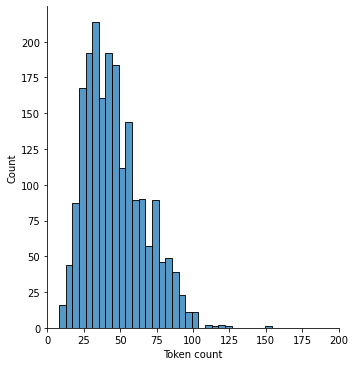

In [15]:
token_lens = []
for txt in list(df.clean_message.values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
sns.displot(token_lens)
plt.xlim([0, 200])
plt.xlabel('Token count')
plt.show()

In [16]:
max_length = 160

### Encode messages

In [18]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_train["clean_message"].values.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].clean_message.values.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_train.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [19]:
len(dataset_train), len(dataset_val)

(1044, 304)

In [268]:
# torch.save(dataset_train, './datasetsLowercase/dataset_train.pt')
# torch.save(dataset_val, './datasetsLowercase/dataset_val.pt')

In [269]:
# dataset_train = torch.load('./datasetsLowercase/dataset_train.pt')
# dataset_val = torch.load('./datasetsLowercase/dataset_val.pt')

In [270]:
# len(dataset_train), len(dataset_val)

# Model "sentence-transformers/LaBSE"

In [20]:
model = AutoModel.from_pretrained('sentence-transformers/LaBSE', num_labels = 3)

Downloading:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

In [21]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

In [22]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)

In [23]:
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

In [24]:
# Function to measure weighted F1

from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [25]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
model.to(device)
print(device)

cpu


In [26]:
# Function to evaluate model. Returns average validation loss, predictions, true values

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    progress_bar = tqdm(dataloader_val, desc='Validating:', leave=False, disable=False)
    for batch in progress_bar:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

# Evaluate untrained LaBSE model

In [27]:
_, predictions, true_vals = evaluate(dataloader_validation)

from sklearn.metrics import classification_report, confusion_matrix

preds_flat = np.argmax(predictions, axis=1).flatten()

print(classification_report(true_vals, preds_flat, zero_division=True))
pd.DataFrame(confusion_matrix(true_vals, preds_flat),
        index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
        columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])

Validating::   0%|          | 0/10 [00:00<?, ?it/s]

TypeError: forward() got an unexpected keyword argument 'labels'

# Train

In [31]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'modelsBase/finetuned_ELECTRA_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    preds_flat = np.argmax(predictions, axis=1).flatten()
    
    print('Classification report:')
    print(classification_report(true_vals, preds_flat))
    print('Confusion matrix:')
    print(pd.DataFrame(confusion_matrix(true_vals, preds_flat),
            index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
            columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']]))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0971832925623113
Validation loss: 1.0909705877304077
F1 Score (Weighted): 0.4069831275876094
Classification report:
              precision    recall  f1-score   support

           0       0.61      0.72      0.66       145
           1       0.26      0.53      0.35        62
           2       0.43      0.03      0.06        97

    accuracy                           0.46       304
   macro avg       0.43      0.43      0.36       304
weighted avg       0.48      0.46      0.41       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral        105       38        2
       positive        27       33        2
       negative        39       55        3


Epoch 2:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.0914946180401426
Validation loss: 1.0824063777923585
F1 Score (Weighted): 0.5628171668841525
Classification report:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       145
           1       0.36      0.34      0.35        62
           2       0.57      0.53      0.55        97

    accuracy                           0.57       304
   macro avg       0.52      0.52      0.52       304
weighted avg       0.56      0.57      0.56       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral        100       20       25
       positive        27       21       14
       negative        28       18       51


Epoch 3:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.0828923023108281
Validation loss: 1.0774479031562805
F1 Score (Weighted): 0.5500664314111977
Classification report:
              precision    recall  f1-score   support

           0       0.70      0.52      0.60       145
           1       0.32      0.47      0.38        62
           2       0.57      0.61      0.59        97

    accuracy                           0.54       304
   macro avg       0.53      0.53      0.52       304
weighted avg       0.58      0.54      0.55       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         76       39       30
       positive        18       29       15
       negative        15       23       59


Epoch 4:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.0786733229955037
Validation loss: 1.0691942930221559
F1 Score (Weighted): 0.5594519137927894
Classification report:
              precision    recall  f1-score   support

           0       0.66      0.57      0.61       145
           1       0.35      0.35      0.35        62
           2       0.56      0.67      0.61        97

    accuracy                           0.56       304
   macro avg       0.52      0.53      0.53       304
weighted avg       0.57      0.56      0.56       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         83       28       34
       positive        22       22       18
       negative        20       12       65


Epoch 5:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 5
Training loss: 1.0728139660575173
Validation loss: 1.068424892425537
F1 Score (Weighted): 0.5555282381532837
Classification report:
              precision    recall  f1-score   support

           0       0.68      0.54      0.60       145
           1       0.33      0.37      0.35        62
           2       0.56      0.68      0.62        97

    accuracy                           0.55       304
   macro avg       0.52      0.53      0.52       304
weighted avg       0.57      0.55      0.56       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         79       33       33
       positive        21       23       18
       negative        17       14       66


# Evaluate

In [210]:
model.load_state_dict(torch.load('modelsBase/finetuned_ELECTRA_epoch_4.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
preds_flat = np.argmax(predictions, axis=1).flatten()

In [ ]:
print(classification_report(true_vals, preds_flat))

In [ ]:
pd.DataFrame(confusion_matrix(true_vals, preds_flat),
        index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
        columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])